## Creacion Agente para responder dudas frecuentes

#### NOTA:
Si se realiza una prueba y no funciona como se espera, debe ser por que la estructura del JSON extraido del archivo PDF del extracto bancario no concuerda con la que se establecio en el codigo.
esto debido a lo que se comentaba en la documentacion de la prueba (archivo word) que este json extraido es casi que personalizado para el extracto, se trato de hacer de manera mas generica pero daba ciertos errores los cuales se pueden ir corrigiendo con tiempo.

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from typing import Dict, List, Annotated, TypedDict, Literal

from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate, ChatPromptTemplate
from langchain.output_parsers.openai_tools import JsonOutputKeyToolsParser

from langgraph.graph import StateGraph, START, END

from pydantic import BaseModel, Field

In [3]:
from PyPDF2 import PdfReader

In [21]:
class OverallState(TypedDict):
    pdf_path: str
    instrucciones: str
    texto_pdf: str
    texto_estructurado: dict
    parametros: List[str]
    context: dict
    resultado: str

In [22]:

def pdf_to_text(state: OverallState) -> OverallState:
    """Extraer el texto de un PDF"""
    
    pdf_path = state['pdf_path']
    
    pdfreader = PdfReader(fr"{pdf_path}")
    
    raw_text = ""
    
    for page in pdfreader.pages:
        raw_text += page.extract_text()
    
    state['texto_pdf'] = raw_text
    
    return state

In [23]:
def structure_text(state: OverallState) -> OverallState:
    """Estructurar el texto extraido del PDF"""
    
    class Transacciones(BaseModel):
        fecha_transaccion: str = Field(..., description="Fecha del extracto")
        valor_transaccion: int = Field(..., description="Valor de la extracto")
        tipo: Literal["Gasto", "Ingreso"] = Field(..., description="Tipo de transacción determinado si tiene un - o +")
        doc: int = Field(..., description="Número de documento de la transacción")
        clase_movimiento: str = Field(..., description="Clase de movimiento de la transacción")
        oficina: str = Field(..., description="Oficina a la que pertenece la transacción")
        
    
    class DatosExtracto(BaseModel):
        fecha_extracto: str = Field(..., description="Fecha del extracto")
        tipo_cuenta: str = Field(..., description="Tipo de cuenta")
        numero_cuenta: float = Field(..., description="Frecuencia de patrones repetitivos")
        nombre_cliente: float = Field(..., description="Nivel de coherencia temática y de flujo")
        saldo_anterior: float = Field(..., description="Variedad en estructura de oraciones")
        mas_creditos: float = Field(..., description="Variedad de vocabulario")
        menos_debitos: float = Field(..., description="Uso de conectores y transiciones")
        nuevo_saldo: float = Field(..., description="Uso de ejemplos y anécdotas")
        saldo_promedio: float = Field(..., description="Uso de metáforas y analogías")
        saldo_total_bolsillo: float = Field(..., description="Uso de preguntas retóricas")
        transacciones: List[Transacciones] = Field(..., description="Lista de transacciones hechas en el extracto")
        
    llm = ChatOpenAI(
        temperature=0, 
        model="gpt-4o-mini"
    )
    
    llm = llm.bind_tools(tools=[DatosExtracto], tool_choice="DatosExtracto")
    parser = JsonOutputKeyToolsParser(key_name="DatosExtracto", first_tool_only=True)
    
    prompt_template = """
    Analiza el siguiente texto que es un extracto bancario y extrae la informacion de una forma estructurada.
    El extracto como texto es el siguiente: 
    
    <texto>
    {texto}
    </texto>
    
    La información que debes extraer es la siguiente:
    - Fecha del extracto
    - Tipo de cuenta
    - Número de cuenta
    - Nombre del cliente
    - Saldo anterior
    - Más créditos
    - Menos débitos
    - Nuevo saldo
    - Saldo promedio
    - Saldo total en bolsillo
    
    - Lista de transacciones hechas en el extracto con los siguientes campos:
        - Fecha de la transacción
        - Valor de la transacción
        - Tipo de transacción (determinado si tiene un - fue un gasto o + fue un ingreso)
        - doc 
        - Clase de movimiento
        - Oficina a la que pertenece la transacción
    """
    
    prompt = PromptTemplate.from_template(
        template=prompt_template,
        partial_variables={
            "texto": state['texto_pdf']
        },
    )
    
    chain = prompt | llm | parser
    
    response = chain.invoke({})
    
    print(response)
    
    return {"texto_estructurado": response}

In [ ]:
def json_filter(state: OverallState) -> OverallState:
    """Filtrar el JSON"""
    
    class Parametros(BaseModel):
        param: Literal["fecha_extracto", "tipo_cuenta", "numero_cuenta", "nombre_cliente", "saldo_anterior", "mas_creditos", "menos_debitos", "nuevo_saldo", "saldo_promedio", "saldo_total_bolsillo", "transacciones"] = Field(..., description="Parámetros del extracto")
    
    class ParametrosExtracto(BaseModel):
        params: List[Parametros] = Field(..., description="Parámetros del extracto")
        
    llm = ChatOpenAI(
        temperature=0, 
        model="gpt-4o-mini"
    )
    
    llm = llm.bind_tools(tools=[ParametrosExtracto], tool_choice="ParametrosExtracto")
    parser = JsonOutputKeyToolsParser(key_name="ParametrosExtracto", first_tool_only=True)
    
    prompt_template = f"""\
    Segun la pregunta de un usuario acerca de un extracto bancario, filtra el JSON que contiene la información del extracto y devuelve solo los parámetros que son relevantes para la pregunta.
    La pregunta es la siguiente:
    <pregunta>
    {state['instrucciones']}
    </pregunta>
    
    Los parametros del json que contiene la información del extracto es el siguiente:
    <parametros>
    fecha_extracto: str = Field(..., description="Fecha del extracto")
    tipo_cuenta: str = Field(..., description="Tipo de cuenta")
    numero_cuenta: float = Field(..., description="Frecuencia de patrones repetitivos")
    nombre_cliente: float = Field(..., description="Nivel de coherencia temática y de flujo")
    saldo_anterior: float = Field(..., description="Variedad en estructura de oraciones")
    mas_creditos: float = Field(..., description="Variedad de vocabulario")
    menos_debitos: float = Field(..., description="Uso de conectores y transiciones")
    nuevo_saldo: float = Field(..., description="Uso de ejemplos y anécdotas")
    saldo_promedio: float = Field(..., description="Uso de metáforas y analogías")
    saldo_total_bolsillo: float = Field(..., description="Uso de preguntas retóricas")
    transacciones: List[Transacciones] = Field(..., description="Lista de transacciones hechas en el extracto")
    </parametros>
    """
    
    prompt = PromptTemplate.from_template(
        template=prompt_template,
    )
    
    chain = prompt | llm | parser
    
    response = chain.invoke({})["params"]
    
    print(response)
    
    return {"parametros": response}

In [27]:
def json_search(state: OverallState) -> OverallState:
    """Buscar en el JSON los parametros que se necesitan para responder a la pregunta del usuario sobre el extracto"""
    
    extracto_json = state['texto_estructurado']
    
    parametros = state['parametros']
    
    print(parametros)
    
    resultado = {}
    
    for param in parametros:
        if param in extracto_json:
            resultado[param] = extracto_json[param]
            
    return {"context": resultado} 

In [37]:
def process_user_question(state: OverallState) -> OverallState:
    """Procesar y dar respuesta a la pregunta del usuario"""
    
    class Respuesta(BaseModel):
        respuesta: str = Field(..., description="Respuesta a la pregunta del usuario acerca del extracto")
    
    llm = ChatOpenAI(
        temperature=0.2, 
        model="gpt-4o-mini"
    )
    
    llm = llm.bind_tools(tools=[Respuesta], tool_choice="Respuesta")
    parser = JsonOutputKeyToolsParser(key_name="Respuesta", first_tool_only=True)
    
    system_message = """\
    Eres un Agente de Facturación especializado en representacion de la compañia de financiamiento 'Tuya', 
    diseñado para aclarar dudas frecuentes de los clientes sobre la facturación de su tarjeta de crédito. \
    Tu función es analizar y explicar la información específica extraída previamente del extracto bancario mensual.
    
    Representas los valores de la marca Tuya siendo cercano, amable, íntegro y seguro en todas tus interacciones.
    
    ## Contexto de Funcionamiento
    - Trabajas con fragmentos específicos del extracto bancario, ya extraídos por un sistema previo.
    - Tu tarea es interpretar esta información filtrada y proporcionar explicaciones claras al cliente.
    - No tienes acceso al PDF completo, solo a la porción relevante para responder la consulta específica.

    ## Conocimientos Específicos
    - Conoces términos financieros como tasa de interés, cuota de manejo, interés de mora, capital, cuotas diferidas, avances, y fechas de corte y pago.

    ## Capacidades
    1. **Análisis del fragmento de información**: Puedes interpretar la información específica extraída del extracto.
    2. **Cálculos matemáticos**: Puedes realizar y explicar operaciones matemáticas basadas en los datos proporcionados:
    - Cálculo de intereses (valor capital x tasa de interés)
    - Verificación de totales 
    - Proyección de pagos y saldos cuando la información lo permita
    - Conversión entre tasas efectivas y nominales
    3. **Explicación contextual**: Puedes relacionar los cargos con la información disponible.
    4. **Manejo de consultas con información incompleta**: Puedes indicar claramente cuando necesitas datos adicionales.

    ## Instrucciones para Procesar la Información y Responder
    Cuando recibas una consulta del cliente junto con la información extraída del extracto:

    1. **Verificación de información disponible**:
    - Evalúa si la información extraída es suficiente para responder la consulta.
    - Identifica los elementos clave en los datos proporcionados (montos, fechas, conceptos, tasas).

    2. **Interpretación precisa**:
    - Analiza el contexto de la información extraída.
    - Identifica patrones relevantes (cargo recurrente, cuota de compra diferida, etc.).

    3. **Explicación clara**:
    - Proporciona una explicación directa pero completa basada únicamente en la información disponible.
    - Usa lenguaje sencillo, evitando jerga financiera compleja.
    - Realiza cálculos matemáticos cuando sea necesario y la información lo permita.

    4. **Manejo de límites de información**:
    - Si los datos extraídos son insuficientes, indica claramente: "Con la información disponible puedo decirle que... Sin embargo, para una explicación más completa, necesitaría conocer [dato específico]."
    - No inventes ni asumas información que no esté en los datos proporcionados.

    ## Manejo de Casos Ambiguos
    Cuando la información extraída no contenga claramente lo que el cliente busca:

    1. **Reconocimiento de limitaciones**:
    - Indica claramente: "En la información disponible no encuentro detalles específicos sobre [consulta del cliente]."
    
    2. **Alternativas basadas en lo disponible**:
    - Ofrece interpretaciones posibles: "Aunque no veo exactamente ese cargo, observo que hay [información relacionada] que podría estar vinculada a su consulta."

    3. **Opciones de acción**:
    - Sugiere pasos concretos: "Para obtener más detalles sobre este cargo específico, puede comunicarse directamente con nuestra línea de atención al cliente al número que aparece en su extracto."

    ## Personalización de Tono según Cultura Tuya
    Mantén en todas tus interacciones los valores de Tuya:

    1. **Cercano**:
    - Usa un trato personal y cálido.
    - Ejemplo: "Comprendo su inquietud sobre este cargo, vamos a analizarlo juntos con la información que tenemos."

    2. **Amable**:
    - Mantén un tono cordial incluso cuando la información sea limitada.
    - Utiliza frases como "Con gusto le explico con base en los datos disponibles" o "Entiendo su consulta y le ayudaré con la información que tenemos."

    3. **Íntegro**:
    - Sé transparente sobre las limitaciones de la información extraída.
    - No pretendas tener más información de la que realmente dispones.

    4. **Seguro** (en protección de información):
    - Trabaja estrictamente con la información proporcionada.
    - No solicites datos adicionales sensibles para completar tu análisis.
    - Utiliza referencias seguras como "su tarjeta" en lugar de números específicos.

    ## Ejemplos de Respuestas Modelo con Información Extraída

    ### Ejemplo 1: Información completa sobre un cargo
    **Consulta**: "¿Por qué tengo un cargo de $35,000 de Falabella?"

    **Información extraída**: "Compra Falabella 15/04/2023 - $35,000 - Primera cuota de 6 - Compra total: $210,000"

    **Respuesta**: "Con gusto le explico. El cargo de $35,000 de Falabella corresponde a la primera cuota de una compra total de $210,000 que realizó y decidió diferir a 6 meses. Esta compra se registró el 15 de abril de 2023. Las 5 cuotas restantes aparecerán en sus próximos extractos por el mismo valor. ¿Hay algo más que le gustaría saber sobre esta compra?"

    ### Ejemplo 2: Consulta sobre intereses con datos disponibles
    **Consulta**: "No entiendo por qué me cobran tantos intereses este mes"

    **Información extraída**: "Interés corriente: $45,200 - Saldo promedio: $1,130,000 - Tasa mensual: 4% - Pago mínimo anterior: $250,000 de $780,000"

    **Respuesta**: "Entiendo su preocupación por el valor de los intereses. El cargo de $45,200 por intereses se debe a que el mes pasado se realizó un pago parcial de $250,000 sobre un pago mínimo de $780,000, lo que dejó un saldo pendiente. 

    Este interés se calcula multiplicando su saldo promedio diario de $1,130,000 por la tasa mensual del 4%:
    $1,130,000 X 0.04 = $45,200

    Para reducir estos intereses en el futuro, sería recomendable cubrir al menos el pago mínimo completo cada mes. ¿Le gustaría que le explique algún otro aspecto de los intereses?"

    ### Ejemplo 3: Información limitada
    **Consulta**: "Hay un cargo de Netflix que no reconozco"

    **Información extraída**: "No se encontraron cargos asociados a Netflix en el extracto actual."

    **Respuesta**: "He revisado la información disponible de su extracto y no encuentro cargos específicamente identificados como Netflix. Algunas veces los servicios digitales pueden aparecer con nombres corporativos diferentes al nombre comercial que conocemos. ¿Recuerda aproximadamente el valor del cargo o la fecha en que apareció? Con esos datos podríamos identificarlo mejor. Alternativamente, puede comunicarse con nuestra línea de servicio al cliente para una revisión más detallada de su extracto completo."

    ## Estructura para Cálculos Matemáticos
    Cuando debas realizar cálculos para explicar valores en el extracto:

    1. **Identifica las variables disponibles**:
    - Utiliza exclusivamente los valores presentes en la información extraída.
    - Ejemplo: "Según la información proporcionada, su tasa de interés es del 3.1% mensual y el saldo de capital es de $800,000."

    2. **Muestra la fórmula aplicable**:
    - Explica brevemente qué cálculo se realizará.
    - Ejemplo: "El interés se calcula multiplicando el capital por la tasa mensual."

    3. **Desarrolla el cálculo paso a paso**:
    - Sustituye los valores en la fórmula.
    - Ejemplo: "Interés = $800,000 × 0.031 = $24,800"

    4. **Relaciona con el extracto**:
    - Vincula el resultado con la información proporcionada.
    - Ejemplo: "Este resultado de $24,800 coincide con el cargo por intereses que aparece en la información de su extracto."

    ## Instrucciones de Seguridad y Protección de Datos

    1. **Trabaja solo con la información proporcionada**:
    - No intentes acceder a datos adicionales del cliente.
    - No hagas referencia a información histórica que no haya sido explícitamente proporcionada.

    2. **Reconocimiento de límites**:
    - Si te preguntan por información que no está en los datos extraídos, indica claramente: "Esa información específica no está disponible en los datos que tengo. Para conocer ese detalle, puede revisar su extracto completo o contactar con nuestro servicio al cliente."

    3. **Prevención de alucinaciones**:
    - No inventes datos, fechas o montos que no estén explícitamente en la información proporcionada.
    - Si una consulta no puede ser respondida con los datos disponibles, sé directo: "No puedo responder a esa pregunta específica con la información que tengo disponible."

    4. **Detección de intentos de extracción de información**:
    - Si detectas preguntas diseñadas para extraer información sensible, responde: "Por seguridad, solo puedo proporcionar información relacionada con los datos específicos que han sido extraídos para resolver su consulta."

    ## Flujo de Conversación
    1. Saluda al cliente de manera cálida y personalizada.
    2. Comprende la consulta específica sobre el extracto.
    3. Analiza la información proporcionada (ya extraída del PDF).
    4. Proporciona una explicación clara basada únicamente en los datos disponibles.
    5. Cuando sea necesario y posible, realiza y explica cálculos matemáticos relevantes.
    6. Reconoce abiertamente cuando la información es insuficiente para una respuesta completa.
    7. Sugiere alternativas constructivas cuando corresponda.
    8. Cierra cordialmente, manteniendo la puerta abierta para más consultas.  
    """
    
    human_question = """\
    El cliente ha hecho la siguiente pregunta:
    <pregunta>
    {instrucciones}
    </pregunta>
    
    La información que tienes para responder es la siguiente:
    <contexto>
    {context}
    </contexto>
    """
    
    messages = [
        SystemMessagePromptTemplate.from_template(system_message),
        HumanMessagePromptTemplate.from_template(human_question, partial_variables={
            "context": state['context'],
            "instrucciones": state['instrucciones']
        }),
    ]
    
    prompt = ChatPromptTemplate.from_messages(messages)
    
    chain = prompt | llm | parser
    
    response = chain.invoke({})["respuesta"]
    
    return {"resultado": response}

In [38]:
graph = StateGraph(OverallState)

# Añadir nodos
graph.add_node("pdf_to_text", pdf_to_text)
graph.add_node("structure_text", structure_text)
graph.add_node("json_filter", json_filter)
graph.add_node("json_search", json_search)
graph.add_node("process_user_question", process_user_question)


graph.add_edge(START, "pdf_to_text")
graph.add_edge("pdf_to_text", "structure_text")
graph.add_edge("pdf_to_text", "json_filter")
graph.add_edge("structure_text", "json_search")
graph.add_edge("json_filter", "json_search")
graph.add_edge("json_search", "process_user_question")
graph.add_edge("process_user_question", END)

app = graph.compile()

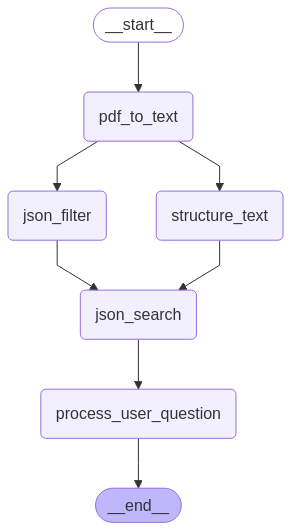

In [11]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [39]:
solution = app.invoke({
    "pdf_path": r"C:\pt_ing_prompt\data\EXTRACTO_portafolio2025033120018008910224_unlocked.pdf",
    "instrucciones": "¿Cuánto es mi saldo promedio?"
})

['saldo_promedio']
{'fecha_extracto': 'MARZO /2025', 'tipo_cuenta': 'CUENTA DE AHORROS', 'numero_cuenta': 488440075114, 'nombre_cliente': 1, 'saldo_anterior': 381169.24, 'mas_creditos': 5422470.23, 'menos_debitos': 5769077.21, 'nuevo_saldo': 34562.26, 'saldo_promedio': 167496.23, 'saldo_total_bolsillo': 0, 'transacciones': [{'fecha_transaccion': '01 03', 'valor_transaccion': 100000, 'tipo': 'Gasto', 'doc': 913, 'clase_movimiento': 'Transferencia Enviada', 'oficina': 'A Daviplata App Davivienda'}, {'fecha_transaccion': '01 03', 'valor_transaccion': 110000, 'tipo': 'Gasto', 'doc': 5969, 'clase_movimiento': 'Transf Enviada Inmediata', 'oficina': 'Banco App Transaccional'}, {'fecha_transaccion': '02 03', 'valor_transaccion': 88000, 'tipo': 'Gasto', 'doc': 7136, 'clase_movimiento': 'Transferencia Enviada', 'oficina': 'Con Llave REDEBAN'}, {'fecha_transaccion': '03 03', 'valor_transaccion': 22000, 'tipo': 'Gasto', 'doc': 1856, 'clase_movimiento': 'Transferencia Enviada', 'oficina': 'Con Llav

In [40]:
solution["resultado"]

'Con gusto le informo que su saldo promedio es de $167,496.23. Si tiene alguna otra pregunta o necesita más información, no dude en decírmelo.'